In [1]:
#IMPORTS

import os
import time
import matplotlib.pyplot as plt
import PIL
import torch
import torch.nn as nn
import torchvision
from torchvision import models,datasets

In [2]:
path_train = '/home/theosiam/Repos/Autotrust/Autotrust/Driver_Distraction_Detection/Datasets/train'
classes = [c for c in os.listdir(path_train) if not c.startswith(".")]
classes.sort()
print(classes)

['c0', 'c1', 'c2', 'c3', 'c4']


In [4]:
class_dict = {0 : "safe driving",
              1 : "texting", 
              2 : "talking on the phone",
              3 : "drinking",
              4 : " reaching behind",
              }

In [5]:
device = torch.device("cuda:0")
print(device)
print(torch.cuda.get_device_name(device))

cuda:0
NVIDIA GeForce GTX 1660


In [6]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),  # Convert to grayscale
    transforms.ToTensor(),  # Convert to tensor before expanding
    transforms.Lambda(lambda x: x.expand(3, -1, -1)),  # Duplicate channel to match RGB format
    transforms.Normalize((0.5,), (0.5,)),  # Normalize for a single grayscale channel
    transforms.RandomRotation((-10, -5)),
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5)
])





In [31]:
data = datasets.ImageFolder(root = path_train, transform = transform)

total_len = len(data)
training_len = int(0.8*total_len)
testing_len = total_len - training_len

training_data,testing_data = torch.utils.data.random_split(data,(training_len,testing_len))

In [32]:
train_loader = torch.utils.data.DataLoader(dataset=training_data,
                                           batch_size=32 ,
                                           shuffle=True,
                                           drop_last=False,
                                           num_workers=2)
test_loader = torch.utils.data.DataLoader(dataset=testing_data,
                                          batch_size=32,
                                          shuffle=False,
                                          drop_last=False,
                                          num_workers=2)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([32, 3, 224, 224])
tensor([[3, 2, 1, 4, 2, 0, 1, 1],
        [2, 4, 4, 2, 1, 0, 3, 1],
        [1, 2, 3, 2, 3, 4, 1, 2],
        [2, 1, 2, 0, 1, 3, 1, 3]])


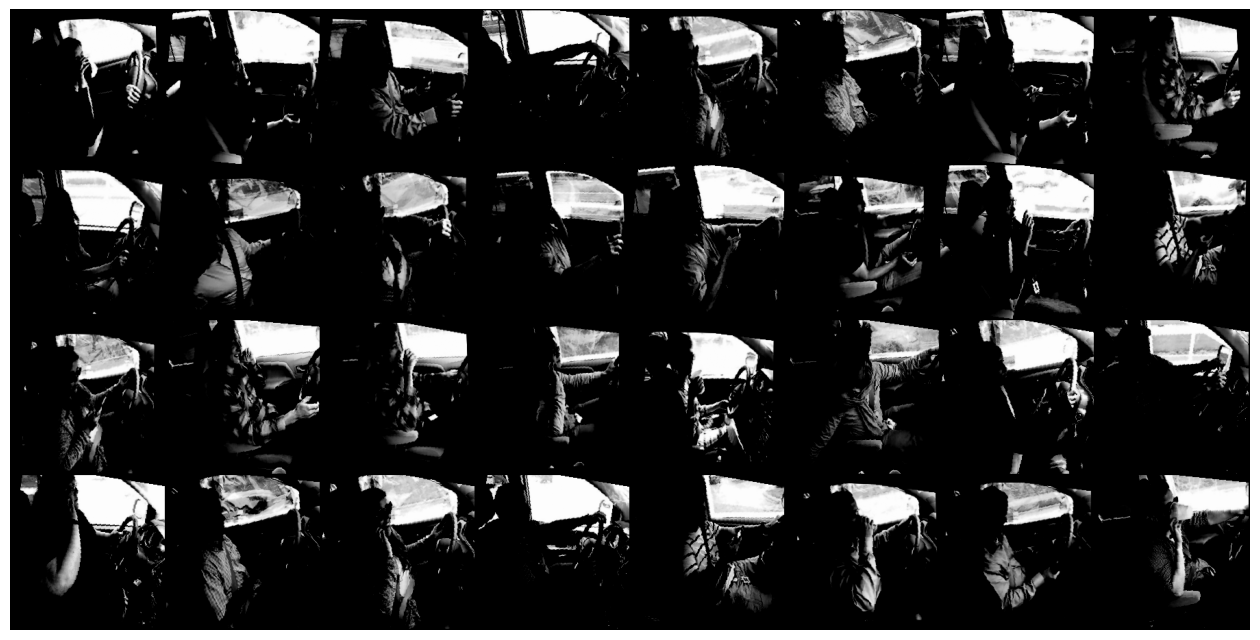

In [33]:
loader,labels = next(iter(train_loader))
print(loader.shape)
print(labels.view(4,8))
plt.figure(figsize=(16,16))
plt.imshow(torchvision.utils.make_grid(loader,nrow=8).permute((1,2,0)))
plt.axis('off')
plt.show()

In [34]:
def train_model(model, criterion, optimizer, scheduler, train_loader, eval_model, device, n_epochs=5, debug_visualize=False):
    """
    Train the model with debugging to visualize inputs.

    Args:
        model: The PyTorch model to train.
        criterion: Loss function.
        optimizer: Optimization algorithm.
        scheduler: Learning rate scheduler.
        train_loader: DataLoader for training data.
        eval_model: Function to evaluate the model on the test set.
        device: Device (CPU or CUDA).
        n_epochs (int): Number of training epochs.
        debug_visualize (bool): Whether to visualize the input images during training.
    
    Returns:
        model: Trained model.
        losses (list): List of training losses per epoch.
        accuracies (list): List of training accuracies per epoch.
        test_accuracies (list): List of test accuracies per epoch.
    """
    import matplotlib.pyplot as plt
    import torchvision

    losses = []
    accuracies = []
    test_accuracies = []
    
    # set the model to train mode initially
    model.train()
    for epoch in range(n_epochs):
        since = time.time()
        running_loss = 0.0
        running_correct = 0.0
        for batch_idx, data in enumerate(train_loader):
            
            # get the inputs and assign them to device
            inputs, labels = data
            inputs = inputs.to(device)
            labels = labels.to(device)

            # Debug visualization of what the model sees
            if debug_visualize and batch_idx == 0 and epoch == 0:  # Only visualize the first batch of the first epoch
                grid_img = torchvision.utils.make_grid(inputs.cpu(), nrow=4, normalize=False, scale_each=True)
                plt.figure(figsize=(10, 10))
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.title("Debug: First batch of inputs (Normalized)")
                plt.axis("off")
                plt.show()

            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            # calculate the loss/acc later
            running_loss += loss.item()
            running_correct += (labels == predicted).sum().item()

        epoch_duration = time.time() - since
        epoch_loss = running_loss / len(train_loader)
        epoch_acc = 100.0 * running_correct / len(train_loader.dataset)

        print("Epoch %s, duration: %d s, loss: %.4f, acc: %.4f" % (epoch + 1, epoch_duration, epoch_loss, epoch_acc))
        
        losses.append(epoch_loss)
        accuracies.append(epoch_acc)
        
        # switch the model to eval mode to evaluate on test data
        model.eval()
        test_acc = eval_model(model)
        test_accuracies.append(test_acc)
        
        # re-set the model to train mode after validating
        model.train()
        scheduler.step(test_acc)
        since = time.time()
    print('Finished Training')
    return model, losses, accuracies, test_accuracies


In [35]:
def eval_model(model, test_loader, device, debug_visualize=False):
    """
    Evaluate the model on the test dataset.

    Args:
        model: Trained PyTorch model.
        test_loader: DataLoader for the test dataset.
        device: Device (CPU or CUDA).
        debug_visualize (bool): Whether to visualize the input images during evaluation.

    Returns:
        float: Test accuracy as a percentage.
    """
    import matplotlib.pyplot as plt
    import torchvision

    model.eval()  # Set model to evaluation mode
    correct = 0.0
    total = 0.0
    with torch.no_grad():  # Disable gradient computation for evaluation
        for i, data in enumerate(test_loader):
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)

            # Debug visualization of what the model sees during evaluation
            if debug_visualize and i == 0:  # Only visualize the first batch
                grid_img = torchvision.utils.make_grid(images.cpu(), nrow=4, normalize=False, scale_each=True)
                plt.figure(figsize=(10, 10))
                plt.imshow(grid_img.permute(1, 2, 0))
                plt.title("Debug: First batch of test inputs (Normalized)")
                plt.axis("off")
                plt.show()
            
            # Forward pass
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            
            # Calculate accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100.0 * correct / total
    print(f'Accuracy of the network on the test images: {test_acc:.2f} %')
    return test_acc

In [36]:
model_ft = models.resnet50(pretrained=True)
num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, 5) #No. of classes = 10
model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_ft.parameters(), lr=0.01, momentum=0.9)
lrscheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', patience=3, threshold = 0.9)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


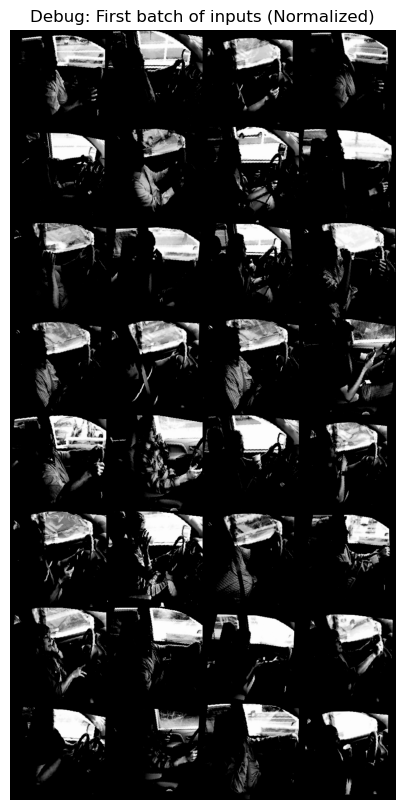

Epoch 1, duration: 168 s, loss: 0.1578, acc: 94.3999
Accuracy of the network on the test images: 99.28 %
Epoch 2, duration: 168 s, loss: 0.0254, acc: 99.2689
Accuracy of the network on the test images: 99.47 %
Finished Training


In [37]:
model_ft, training_losses, training_accs, test_accs = train_model(
    model=model_ft,
    criterion=criterion,
    optimizer=optimizer,
    scheduler=lrscheduler,
    train_loader=train_loader,
    eval_model=lambda m: eval_model(m, test_loader, device),
    device=device,
    n_epochs=2,
    debug_visualize=True  # Enable visualization during training
)

In [38]:
torch.save(model_ft.state_dict(), "/home/theosiam/Repos/Autotrust/Autotrust/Driver_Distraction_Detection/Weight_versions/w6")